# BiGRU for forecast

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
import torch
import torch.nn as nn
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
from xgboost import XGBRegressor

if torch.cuda.is_available():  
    dev = "cuda:0" 
else:  
    dev = "cpu"
device = torch.device(dev)

In [2]:
def random_seed_set(seed):
    np.random.seed(seed)
    torch.random.manual_seed(seed)
    torch.cuda.random.manual_seed(seed)
#     torch.backends.cudnn.benchmark = False
#     torch.backends.cudnn.deterministic = True

## load data

In [3]:
url = '../data/beijing.csv'
data = pd.read_csv(url, sep=',', index_col='time')
data.index = pd.to_datetime(data.index)

## normalization

In [4]:
def normalization(data):
    """
    data: original data with load
    return: normalized data, scaler of load
    """
    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(data)
    scaler_y = MinMaxScaler()
    scaler_y.fit_transform(data[[data.columns[-1]]])
    return normalized_data, scaler, scaler_y

## build supervised dataset

In [5]:
def series_to_supervise(data, seq_len, target_len):
    """
    convert series data to supervised data
    :param data: original data
    :param seq_len: length of input sequence
    :param target_len: length of ouput sequence
    :return: return two ndarrays-- input and output in format suitable to feed to RNN
    """
    dim_0 = data.shape[0] - seq_len - target_len + 1
    dim_1 = data.shape[1]
    x = np.zeros((dim_0, seq_len, dim_1))
    y = np.zeros((dim_0, target_len))
    for i in range(dim_0):
        x[i] = data[i:i + seq_len]
        y[i] = data[i + seq_len:i + seq_len + target_len, -1]
    print("supervised data: shape of x: {}, shape of y: {}".format(x.shape, y.shape))
    return x, y

## 5-folds TimeSeriesSplit

In [6]:
def time_series_split(X, Y, n_split=5):
    """
    X: features, size * seq_len * feature_num
    Y: labels, size * target_len
    return: list of train_x, test_x, train_y, test_y
    """
    tscv = TimeSeriesSplit(n_splits=n_split)
    train_x_list = list()
    valid_x_list = list()
    train_y_list = list()
    valid_y_list = list()
    for train_index, valid_index in tscv.split(X):
        train_x_list.append(X[train_index])
        train_y_list.append(Y[train_index])
        valid_x_list.append(X[valid_index])
        valid_y_list.append(Y[valid_index])
    return train_x_list, train_y_list, valid_x_list, valid_y_list

## GRU model

In [25]:
class GRU(nn.Module):
    def __init__(self, input_size, output_size, hidden_dim, n_layers,
                 drop_prob):
        super(GRU, self).__init__()
        # model parameters
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.output_size = output_size
        # layes
        self.gru = nn.GRU(input_size=input_size,
                           hidden_size=hidden_dim,
                           num_layers=n_layers,
                           dropout=drop_prob,
                           bidirectional=True)
        self.fc = nn.Sequential()

        input_size = hidden_dim * 2
        i = 0
        while (input_size > 8):
            self.fc.add_module('linear{}'.format(i),
                               nn.Linear(input_size, round(input_size / 2)))
            self.fc.add_module('relu{}'.format(i), nn.ReLU())
            input_size = round(input_size / 2)
            i += 1
        self.fc.add_module('linear{}'.format(i), nn.Linear(input_size, 1))

    # predict using outputs of the last 24 steps
    def forward(self, x):
        x = torch.transpose(x, 0, 1)
        gru_out, hidden = self.gru(x)
        gru_out = gru_out[-self.output_size:, :, :]

        out = self.fc(gru_out)
        out = torch.transpose(out, 0, 1)
        out = out.reshape(out.shape[0], -1)

        return out

## model training for HPO

In [8]:
def train_model_hpo(train_x_list, train_y_list, valid_x_list, valid_y_list,
                    input_size, output_size, mse_thresh, batch_size, lr,
                    number_epoch, hidden_dim, n_layers, drop_prob, weight_decay):
    valid_loss_list = []
    for num in range(len(train_x_list)):
        while (1):
            model = GRU(input_size, output_size, hidden_dim, n_layers,
                           drop_prob)
            model.to(device=device)
            criterion = nn.MSELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.98)
            valid_loss_min = np.Inf
            print('cross-validation dataset {}'.format(num))
            train_x = train_x_list[num]
            train_y = train_y_list[num]
            valid_x = valid_x_list[num]
            valid_y = valid_y_list[num]
            train_dataset = TensorDataset(torch.FloatTensor(train_x),
                                          torch.FloatTensor(train_y))
            valid_dataset = TensorDataset(torch.FloatTensor(valid_x),
                                          torch.FloatTensor(valid_y))
            train_loader = DataLoader(dataset=train_dataset,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      drop_last=False)
            valid_loader = DataLoader(dataset=valid_dataset,
                                      batch_size=batch_size,
                                      shuffle=True,
                                      drop_last=False)
            num_without_imp = 0
            # training process
            for epoch in range(1, number_epoch + 1):
                loop = tqdm(enumerate(train_loader),
                            total=len(train_loader),
                            leave=True)
                for i, (inputs, labels) in loop:
                    inputs = inputs.to(device=device)
                    labels = labels.to(device=device)
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()
                    if i % 5 == 0:
                        num_without_imp = num_without_imp + 1
                        valid_losses = list()
                        model.eval()
                        for inp, lab in valid_loader:
                            inp = inp.to(device)
                            lab = lab.to(device)
                            out = model(inp)
                            valid_loss = criterion(out, lab)
                            valid_losses.append(valid_loss.item())

                        model.train()
                        loop.set_description("Epoch: {}/{}".format(
                            epoch, number_epoch))
                        loop.set_postfix(train_loss=loss.item(),
                                         valid_loss=np.mean(valid_losses))
                        if np.mean(valid_losses) < valid_loss_min:
                            num_without_imp = 0
                            valid_loss_min = np.mean(valid_losses)
                scheduler.step()
                if num_without_imp >= 50:
#                     break
                    pass
            if valid_loss_min < mse_thresh:
                valid_loss_list.append(valid_loss_min)
                break
    return np.mean(valid_loss_list)

## hyper-parameters config

In [9]:
seq_len = 72
target_len = 24
mse_thresh = 0.05


def model_config():
    batch_sizes = [256]
    lrs = [0.01]
    number_epochs = [30]
    hidden_dims = [64, 128, 256]
    n_layers = [2, 3]
    drop_prob = [0]
    weight_decays = [0]
    configs = list()
    for i in batch_sizes:
        for j in lrs:
            for k in number_epochs:
                for l in hidden_dims:
                    for m in n_layers:
                        for n in drop_prob:
                            for o in weight_decays:
                                configs.append({
                                    'batch_size': i,
                                    'lr': j,
                                    'number_epoch': k,
                                    'hidden_dim': l,
                                    'n_layers': m,
                                    'drop_prob': n,
                                    'weight_decay': o,
                                })
    return configs

## random search for HPO

In [10]:
def run_model_hpo(seq_len=seq_len,
                  target_len=target_len,
                  mse_thresh=mse_thresh):
    train_data = data[:int(0.8 * len(data))]
    train_data, _, _ = normalization(train_data)
    train_x, train_y = series_to_supervise(train_data, seq_len, target_len)
    train_x_list, train_y_list, valid_x_list, valid_y_list = time_series_split(
        train_x, train_y)
    #     with enough data
    train_x_list = train_x_list[-1:]
    train_y_list = train_y_list[-1:]
    valid_x_list = valid_x_list[-1:]
    valid_y_list = valid_y_list[-1:]

    configs = model_config()
    records = []
    input_size = train_x.shape[2]
    output_size = target_len
    for i in range(6):
        config = random.choice(configs)
        configs.remove(config)
        batch_size = config['batch_size']
        lr = config['lr']
        number_epoch = config['number_epoch']
        hidden_dim = config['hidden_dim']
        n_layers = config['n_layers']
        drop_prob = config['drop_prob']
        weight_decay = config['weight_decay']
        print(
            "model config: batch_size-{}, lr-{}, number_epoch-{}, hidden_dim-{}, n_layers-{},drop_prob-{},weight_decay-{}"
            .format(batch_size, lr, number_epoch, hidden_dim, n_layers,
                    drop_prob, weight_decay))
        valid_loss = train_model_hpo(train_x_list, train_y_list, valid_x_list,
                                     valid_y_list, input_size, output_size,
                                     mse_thresh, batch_size, lr, number_epoch,
                                     hidden_dim, n_layers, drop_prob, weight_decay)
        records.append({
            'batch_size': batch_size,
            'lr': lr,
            'number_epoch': number_epoch,
            'hidden_dim': hidden_dim,
            'n_layers': n_layers,
            'drop_prob': drop_prob,
            'weight_decay': weight_decay,
            'valid_loss': valid_loss
        })
    return records

## run random search

In [15]:
random_seed_set(16)
records = run_model_hpo()

supervised data: shape of x: (25232, 72, 16), shape of y: (25232, 24)
model config: batch_size-256, lr-0.01, number_epoch-30, hidden_dim-64, n_layers-2,drop_prob-0,weight_decay-0
cross-validation dataset 0


Epoch: 30/30: 100%|██████████| 83/83 [00:01<00:00, 51.96it/s, train_loss=0.000328, valid_loss=0.00378]


model config: batch_size-256, lr-0.01, number_epoch-30, hidden_dim-128, n_layers-2,drop_prob-0,weight_decay-0
cross-validation dataset 0


Epoch: 30/30: 100%|██████████| 83/83 [00:02<00:00, 31.52it/s, train_loss=5.55e-5, valid_loss=0.00364]


model config: batch_size-256, lr-0.01, number_epoch-30, hidden_dim-256, n_layers-3,drop_prob-0,weight_decay-0
cross-validation dataset 0


Epoch: 30/30: 100%|██████████| 83/83 [00:04<00:00, 19.48it/s, train_loss=0.031, valid_loss=0.035]  


model config: batch_size-256, lr-0.01, number_epoch-30, hidden_dim-128, n_layers-3,drop_prob-0,weight_decay-0
cross-validation dataset 0


Epoch: 30/30: 100%|██████████| 83/83 [00:03<00:00, 25.40it/s, train_loss=0.0307, valid_loss=0.0356]


model config: batch_size-256, lr-0.01, number_epoch-30, hidden_dim-64, n_layers-3,drop_prob-0,weight_decay-0
cross-validation dataset 0


Epoch: 30/30: 100%|██████████| 83/83 [00:03<00:00, 25.71it/s, train_loss=0.00113, valid_loss=0.0028]  


model config: batch_size-256, lr-0.01, number_epoch-30, hidden_dim-256, n_layers-2,drop_prob-0,weight_decay-0
cross-validation dataset 0


Epoch: 30/30: 100%|██████████| 83/83 [00:02<00:00, 32.20it/s, train_loss=0.0296, valid_loss=0.0349]


## find the best hyper-parameters

In [16]:
records = pd.DataFrame(records).sort_values(by='valid_loss')
records.to_csv('./records/GRU_records.csv', mode='a', index=False, header=False)
records

,batch_size,lr,number_epoch,hidden_dim,n_layers,drop_prob,weight_decay,valid_loss
1,256,0.01,30,128,2,0,0,0.002356
0,256,0.01,30,64,2,0,0,0.002439
4,256,0.01,30,64,3,0,0,0.002467
5,256,0.01,30,256,2,0,0,0.019121
3,256,0.01,30,128,3,0,0,0.034462
2,256,0.01,30,256,3,0,0,0.034503


## retrain a model

In [17]:
def train_model(train_x, train_y, valid_x, valid_y, input_size, output_size,
                mse_thresh, batch_size, lr, number_epoch, hidden_dim, n_layers,
                drop_prob, weight_decay):
    while (1):
        model = GRU(input_size, output_size, hidden_dim, n_layers,
                       drop_prob)
        model.to(device=device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.98)
        valid_loss_min = np.Inf
        train_dataset = TensorDataset(torch.FloatTensor(train_x),
                                      torch.FloatTensor(train_y))
        valid_dataset = TensorDataset(torch.FloatTensor(valid_x),
                                      torch.FloatTensor(valid_y))
        train_loader = DataLoader(dataset=train_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  drop_last=False)
        valid_loader = DataLoader(dataset=valid_dataset,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  drop_last=False)
        num_without_imp = 0
        train_loss_list = []
        valid_loss_list = []
        # training process
        for epoch in range(1, number_epoch + 1):
            loop = tqdm(enumerate(train_loader),
                        total=len(train_loader),
                        leave=True, ncols=100)
            for i, (inputs, labels) in loop:
                inputs = inputs.to(device=device)
                labels = labels.to(device=device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                if i % 5 == 0:
                    num_without_imp = num_without_imp + 1
                    valid_losses = list()
                    model.eval()
                    for inp, lab in valid_loader:
                        inp = inp.to(device)
                        lab = lab.to(device)
                        out = model(inp)
                        valid_loss = criterion(out, lab)
                        valid_losses.append(valid_loss.item())

                    model.train()
                    loop.set_description("Epoch: {}/{}".format(
                        epoch, number_epoch))
                    loop.set_postfix(train_loss=loss.item(),
                                     valid_loss=np.mean(valid_losses))
                    
                    train_loss_list.append(loss.item())
                    valid_loss_list.append(np.mean(valid_losses))
                    if np.mean(valid_losses) < valid_loss_min:
                        num_without_imp = 0
                        torch.save(model.state_dict(),
                                   './model/GRU_state_dict.pt')
                        valid_loss_min = np.mean(valid_losses)
            scheduler.step()
        if valid_loss_min < mse_thresh:
            break
    return model, train_loss_list, valid_loss_list

## test results

In [12]:
def test_model(model, test_x, test_y, scaler_y, batch_size):
    test_dataset = TensorDataset(torch.FloatTensor(test_x),
                                 torch.FloatTensor(test_y))
    test_loader = DataLoader(dataset=test_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             drop_last=False)
    model.load_state_dict(torch.load('./model/GRU_state_dict.pt'))
    y_pred = []
    y_true = []
    with torch.no_grad():
        for inputs, label in test_loader:
            inputs = inputs.to(device)
            label = label.to(device)
            outputs = model(inputs)
            y_pred += outputs.cpu().numpy().flatten().tolist()
            y_true += label.cpu().numpy().flatten().tolist()
    y_pred = np.array(y_pred).reshape(-1, 1)
    y_true = np.array(y_true).reshape(-1, 1)
#     pdb.set_trace()
    load_pred = scaler_y.inverse_transform(y_pred)
    load_true = scaler_y.inverse_transform(y_true)
    MAPE = np.mean(np.abs(load_true - load_pred) / load_true)
    MAE = np.mean(np.abs(load_true - load_pred))
    RMSE = np.sqrt(np.mean(np.square(load_true - load_pred)))
    return MAPE, MAE, RMSE, load_pred, load_true

## run model retraining

In [27]:
def run_model_retraining(seq_len=seq_len,
                         target_len=target_len,
                         mse_thresh=mse_thresh):
    train_data = data[:int(0.8 * len(data))]
    #     train_data = data[:-800]
    train_data, scaler, scaler_y = normalization(train_data)
    train_x, train_y = series_to_supervise(train_data, seq_len, target_len)

    valid_x = train_x[int(0.8 * len(train_x)):]
    valid_y = train_y[int(0.8 * len(train_y)):]
    train_x = train_x[:int(0.8 * len(train_x))]
    train_y = train_y[:int(0.8 * len(train_y))]
    input_size = train_x.shape[2]
    output_size = target_len

    #     hyper-parameters define
    batch_size = 256
    lr = 0.01
    number_epoch = 80
    hidden_dim = 64
    n_layers = 3
    drop_prob = 0
    weight_decay = 0
    mse_thresh = 0.01

    model, train_loss_list, valid_loss_list = train_model(
        train_x, train_y, valid_x, valid_y, input_size, output_size,
        mse_thresh, batch_size, lr, number_epoch, hidden_dim, n_layers,
        drop_prob, weight_decay)
    
    # plot training process
    plt.plot(train_loss_list[10:], 'm', label='train_loss')
    plt.plot(valid_loss_list[10:], 'g', label='valid_loss')
    plt.grid('both')
    plt.legend()
    
    # test
    test_data = data[int(0.8 * len(data)):]
    #     test_data = data[-800:]
    test_data = scaler.transform(test_data)
    test_x, test_y = series_to_supervise(test_data, seq_len, target_len)
    MAPE, MAE, RMSE, load_pred, load_true = test_model(model, test_x, test_y,
                                                       scaler_y, batch_size)
    return MAPE, MAE, RMSE, load_pred, load_true

supervised data: shape of x: (25232, 72, 16), shape of y: (25232, 24)


Epoch: 80/80: 100%|█████████| 79/79 [00:04<00:00, 18.82it/s, train_loss=4.87e-5, valid_loss=0.00259]


supervised data: shape of x: (6237, 72, 16), shape of y: (6237, 24)
MAPE:0.03621506769883562, MAE:480.48737157153744, RMSE:701.2232097649317


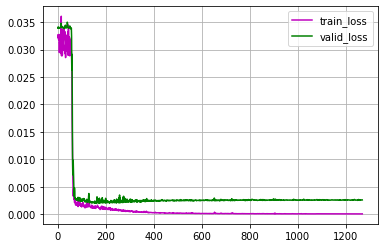

In [28]:
random_seed_set(16)
MAPE, MAE, RMSE, load_pred, load_true = run_model_retraining()
print('MAPE:{}, MAE:{}, RMSE:{}'.format(MAPE, MAE, RMSE))

In [29]:
print('MAPE:{}, MAE:{}, RMSE:{}'.format(MAPE, MAE, RMSE))

MAPE:0.03621506769883562, MAE:480.48737157153744, RMSE:701.2232097649317


## figure plot

(0.0, 19468.726825550675)

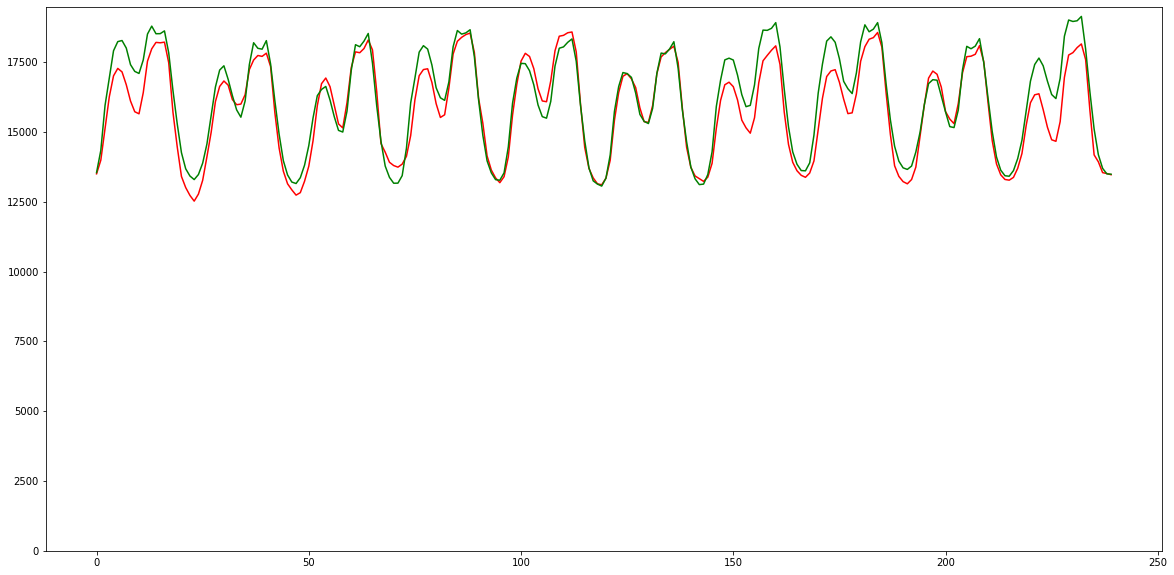

In [30]:
plt.figure(figsize=(20, 10))
load_pred = load_pred.reshape(-1, target_len)
load_true = load_true.reshape(-1, target_len)
plt.plot(load_pred[:240,0], 'r')
plt.plot(load_true[:240,0], 'g')
plt.ylim(0)